# 01_Data_Cleaning.ipynb

This notebook loads the raw trade data (combined_files.zip), performs basic cleaning, removes lookahead features, handles missing values, checks correlations, and saves cleaned outputs for further feature engineering.

In [1]:
import pandas as pd, numpy as np, zipfile, io, matplotlib.pyplot as plt, seaborn as sns
from pathlib import Path
DATA_DIR = Path('data')
RAW_DIR = DATA_DIR / 'raw'
INTERIM_DIR = DATA_DIR / 'interim'
INTERIM_DIR.mkdir(parents=True, exist_ok=True)


## Load combined_files.zip

In [2]:
zip_path = RAW_DIR / 'combined_files.zip'
if zip_path.exists():
    zf = zipfile.ZipFile(zip_path)
    df = None
    for n in zf.namelist():
        if n.endswith('.csv'):
            df = pd.read_csv(io.BytesIO(zf.read(n)))
            break
        if n.endswith('.parquet'):
            df = pd.read_parquet(io.BytesIO(zf.read(n)))
            break
    print('Loaded rows:', len(df))
else:
    raise FileNotFoundError('combined_files.zip not found in data/raw/')
display(df.head())

Loaded rows: 46652


,trade_id,name,symbol,signal,strategy,entry_date,exit_date,entry_cost,exit_cost,pnl,...,min_put_wall_strike_perc_exp_mean,min_put_wall_strike_low_vs_hist,min_put_wall_strike_high_vs_hist,min_put_wall_strike_not_near,neutral_zone,call_wall_compression,put_wall_compression,short_gamma_expansion,gamma_valley,wall_to_wall_compression
0,0,renko_AAPL_long_1.0_1.0,AAPL,3,stock_only,2023-04-24 17:15:00+00:00,2023-04-24 19:50:00+00:00,164.68,-165.1786,0.4986,...,-0.027566,False,True,False,False,False,False,True,False,False
1,1,renko_AAPL_long_1.0_1.0,AAPL,16,stock_only,2023-05-03 13:35:00+00:00,2023-05-03 14:15:00+00:00,170.27,-170.2200,-0.0500,...,-0.033318,True,False,True,False,False,False,False,True,True
2,2,renko_AAPL_long_1.0_1.0,AAPL,17,stock_only,2023-05-03 16:00:00+00:00,2023-05-03 19:10:00+00:00,169.73,-168.8800,-0.8500,...,-0.033318,True,False,True,False,False,False,False,True,True
3,3,renko_AAPL_long_1.0_1.0,AAPL,27,stock_only,2023-05-10 18:10:00+00:00,2023-05-10 19:50:00+00:00,172.74,-173.5250,0.7850,...,-0.035424,False,True,True,False,True,True,False,False,True
4,4,renko_AAPL_long_1.0_1.0,AAPL,28,stock_only,2023-05-11 14:50:00+00:00,2023-05-11 17:50:00+00:00,173.13,-173.4101,0.2801,...,-0.034841,False,True,True,False,True,True,False,False,True


## Drop lookahead and non-predictive columns

In [3]:
drop_cols = ['exit_date','exit_cost','pnl','entry_cost','name','strategy']
df_clean = df.drop(columns=[c for c in drop_cols if c in df.columns], errors='ignore')

# create label
df_clean['label'] = (df['pnl'] > 0).astype(int) if 'pnl' in df.columns else 0
print('Remaining columns:', len(df_clean.columns))

Remaining columns: 32


## Handle missing values

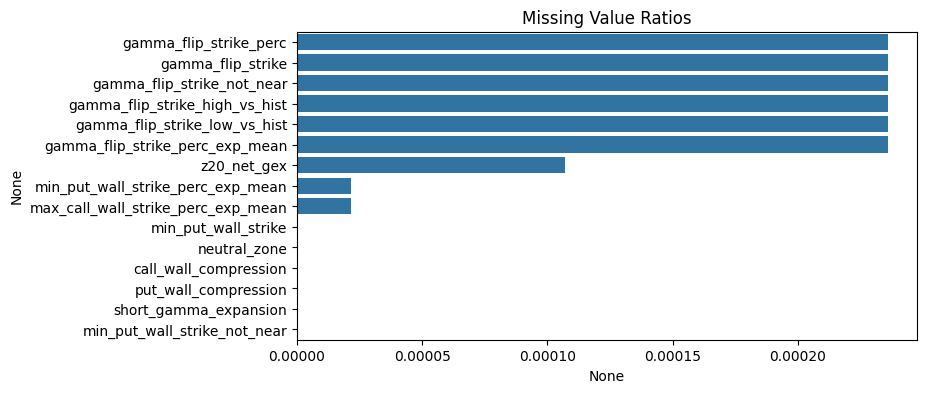

Dropped columns with >50% NA: []


In [4]:
na_ratio = df_clean.isna().mean().sort_values(ascending=False)
plt.figure(figsize=(8,4))
sns.barplot(x=na_ratio.head(15), y=na_ratio.head(15).index)
plt.title('Missing Value Ratios')
plt.show()

threshold = 0.5
drop_na_cols = na_ratio[na_ratio > threshold].index.tolist()
df_clean = df_clean.drop(columns=drop_na_cols)

# fill remaining NaNs
df_clean = df_clean.fillna(df_clean.median(numeric_only=True))
print('Dropped columns with >50% NA:', drop_na_cols)

## Remove low variance & highly correlated features

In [5]:
from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold(threshold=1e-5)
num_cols = df_clean.select_dtypes(include=np.number).columns
df_var = df_clean[num_cols].copy()
selector.fit(df_var)
kept_cols = num_cols[selector.get_support()]
df_var = df_var[kept_cols]

corr = df_var.corr().abs()
upper = corr.where(~np.tril(np.ones(corr.shape)).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
print('Highly correlated columns dropped:', to_drop)
df_var = df_var.drop(columns=to_drop)

# merge cleaned numeric part back with non-numeric
non_num = df_clean.drop(columns=num_cols)
df_final = pd.concat([non_num, df_var], axis=1)
df_final.to_parquet(INTERIM_DIR / 'cleaned_trades.parquet', index=False)
print('Saved cleaned dataset:', INTERIM_DIR / 'cleaned_trades.parquet')

Highly correlated columns dropped: ['max_call_wall_strike', 'max_call_wall_strike_perc', 'max_call_wall_strike_perc_exp_mean', 'min_put_wall_strike', 'min_put_wall_strike_perc', 'min_put_wall_strike_perc_exp_mean']
Saved cleaned dataset: data\interim\cleaned_trades.parquet


## Train/Test Split (saved for convenience)

In [6]:
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
X = df_final.drop(columns=['label'], errors='ignore')
y = df_final['label']
train_idx, test_idx = next(sss.split(X, y))
train, test = df_final.iloc[train_idx], df_final.iloc[test_idx]
train.to_parquet(INTERIM_DIR / 'train_pre_split.parquet', index=False)
test.to_parquet(INTERIM_DIR / 'test_pre_split.parquet', index=False)
print('Train/Test split saved in interim directory')

Train/Test split saved in interim directory


## Basic Statistics & Correlation Heatmap

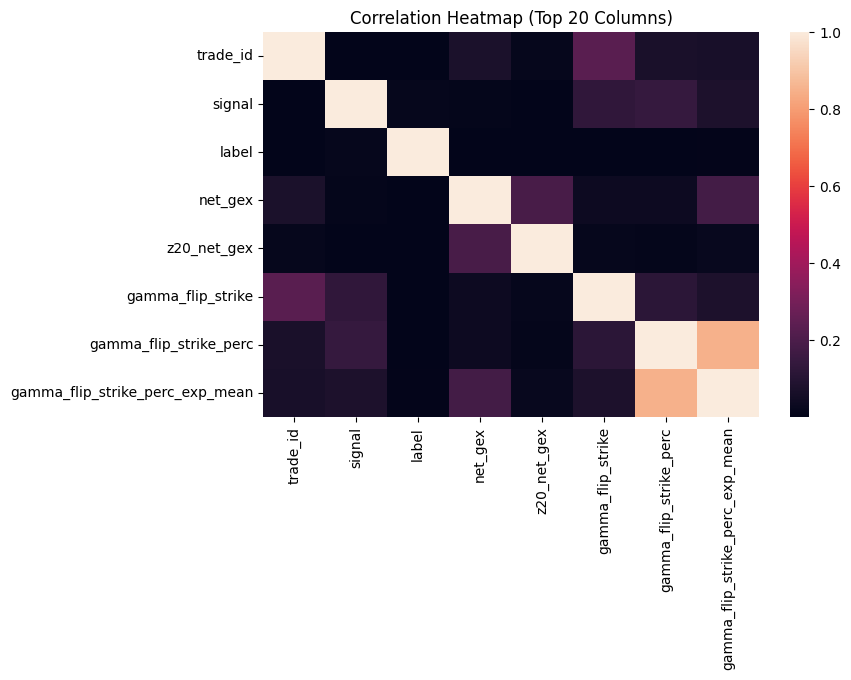

,count,mean,std,min,25%,50%,75%,max
trade_id,46652.0,2.332550e+04,1.346742e+04,0.000000e+00,11662.750000,2.332550e+04,3.498825e+04,4.665100e+04
signal,46652.0,6.463949e+02,3.747283e+02,0.000000e+00,325.000000,6.430000e+02,9.670000e+02,1.574000e+03
label,46652.0,4.312355e-01,4.952542e-01,0.000000e+00,0.000000,0.000000e+00,1.000000e+00,1.000000e+00
net_gex,46652.0,9.194507e+06,6.009260e+07,-6.653617e+08,-544713.189506,1.050405e+06,6.653217e+06,6.237220e+09
z20_net_gex,46652.0,-2.548766e-03,1.251454e+00,-4.246150e+00,-0.928092,-5.348297e-02,9.211333e-01,4.245023e+00
gamma_flip_strike,46652.0,3.697784e+02,6.309528e+02,1.400000e+01,109.000000,1.980000e+02,4.120000e+02,5.730000e+03
gamma_flip_strike_perc,46652.0,2.016297e-01,1.314843e+00,-3.120000e-01,-0.018453,-2.856327e-04,1.769431e-02,1.008947e+01
gamma_flip_strike_perc_exp_mean,46652.0,3.203219e-01,1.540779e+00,-6.097693e-02,-0.005569,-1.522979e-03,2.841710e-03,9.132898e+00


In [7]:
plt.figure(figsize=(8,5))
sns.heatmap(df_var.corr().abs().head(20), annot=False)
plt.title('Correlation Heatmap (Top 20 Columns)')
plt.show()

display(df_final.describe().T.head(15))